In [165]:
import pandas as pd
import numpy as np

import seaborn as sns
import networkx as nx
from matplotlib import pyplot as plt
import altair as alt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
    mean_absolute_error,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
import warnings

warnings.filterwarnings("ignore")  # Ignore warnings for cleaner output

from prettytable import PrettyTable, TableStyle
from scipy.stats import skew

# Data Analysis Begins

- Load data

In [166]:
def load_data(option: str = "1985-2023") -> pd.DataFrame:
    """
    Load a dataset based on the specified time range.

    This function reads an Excel file containing the dataset for the specified time range
    and returns it as a pandas DataFrame. Two options are currently available:
    "1985-2023" or "2010-2023".

    Args:
        option (str, optional): A string indicating the time range for the dataset.
            Defaults to "1985-2023".
            - "1985-2023": Loads data from 'tentative_final_with_NaN.xlsx'.
            - "2010-2023": Loads data from 'tentative_final.xlsx'.

    Returns:
        pd.DataFrame: A DataFrame containing the dataset for the specified time range.

    Raises:
        FileNotFoundError: If the specified Excel file is not found.
        ValueError: If an invalid option is provided.

    Example:
        >>> df = load_data(option="2010-2023")
        >>> print(df.head())
    """
    df = pd.DataFrame()
    if option == "1985-2023":
        df = pd.read_excel("../data/tentative_final_with_NaN.xlsx")
    elif option == "2010-2023":
        df = pd.read_excel("../data/tentative_final.xlsx")
    else:
        raise ValueError("Invalid option. Choose either '1985-2023' or '2010-2023'.")
    return df

### Load and view data

In [167]:
tentative_df = load_data(option="2010-2023")
tentative_df

,County,Year,Population,crime_rate,clearance_rate,population_density,unemployment_rate,adjusted_income,poverty_rate,rent_burden,...,adj_prison_budget,median_house_value,house_affordability,Category,Category_encoded,Category_Rural,Category_Suburban,Category_Urban,uninsured_rate,high_school_rate
0,Alameda,2010,1510271,0.006931,0.326901,2046.437669,11.2,294.981910,13.5,42.4,...,0.664076,590900,8.827704,Urban,2,0,0,1,0.132639,85.9
1,Alameda,2011,1527169,0.007062,0.294298,2069.334688,10.3,288.906538,13.2,42.3,...,0.649141,558300,8.296307,Urban,2,0,0,1,0.128512,86.0
2,Alameda,2012,1549193,0.007681,0.247584,2099.177507,8.8,294.803804,13.1,42.6,...,0.611663,514900,7.333818,Urban,2,0,0,1,0.123669,86.2
3,Alameda,2013,1575139,0.007453,0.251895,2134.334688,7.3,298.514628,13.0,42.6,...,0.600055,493800,6.846162,Urban,2,0,0,1,0.125603,41.8
4,Alameda,2014,1597747,0.006482,0.297316,2164.968835,5.9,312.921908,12.5,43.0,...,0.631766,509300,6.614629,Urban,2,0,0,1,0.117792,86.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,Yuba,2012,73501,0.003877,0.470175,116.668254,15.6,174.671957,22.4,45.2,...,1.113337,180700,4.343854,Rural,0,1,0,0,0.153530,78.4
698,Yuba,2013,74114,0.003670,0.496324,117.641270,13.3,173.096104,20.6,48.6,...,1.052415,171000,4.088562,Rural,0,1,0,0,0.166095,13.7
699,Yuba,2014,74755,0.003960,0.500000,118.658730,11.3,168.267257,21.6,49.1,...,1.031046,170800,4.125305,Rural,0,1,0,0,0.161760,79.6
700,Yuba,2015,75374,0.004153,0.437700,119.641270,9.3,186.248828,21.6,48.9,...,1.068289,172100,3.701075,Rural,0,1,0,0,0.142650,80.8


In [168]:
tentative_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   County                        702 non-null    object 
 1   Year                          702 non-null    int64  
 2   Population                    702 non-null    int64  
 3   crime_rate                    702 non-null    float64
 4   clearance_rate                702 non-null    float64
 5   population_density            702 non-null    float64
 6   unemployment_rate             702 non-null    float64
 7   adjusted_income               702 non-null    float64
 8   poverty_rate                  702 non-null    float64
 9   rent_burden                   702 non-null    float64
 10  home_ownership_rate           702 non-null    float64
 11  mobile_home_ratio             702 non-null    float64
 12  vacancy_rate                  702 non-null    float64
 13  Total

In [169]:
def add_new_features(df: pd.DataFrame, features: dict) -> pd.DataFrame:
    """
    Add new features (columns) to a given DataFrame.

    This function takes an existing DataFrame and a dictionary of features,
    where keys are column names and values are the data to be added. It creates
    a copy of the original DataFrame, adds the new features to it, and returns
    the updated DataFrame.

    Args:
        df (pd.DataFrame): The original DataFrame to which new features will be added.
        features (dict): A dictionary where:
            - Keys are the names of the new columns to be added.
            - Values are the data for each corresponding column (as lists or arrays).

    Returns:
        pd.DataFrame: A new DataFrame with the added features.

    Example:
        >>> df = pd.DataFrame({"A": [1, 2, 3]})
        >>> features = {"B": [4, 5, 6], "C": [7, 8, 9]}
        >>> new_df = add_new_features(df, features)
        >>> print(new_df)
           A  B  C
        0  1  4  7
        1  2  5  8
        2  3  6  9
    """
    new_df = df.copy()
    for key, val in features.items():
        new_df[key] = val
    return new_df

In [170]:
def choose_dataframe(df, option, new_features: dict) -> tuple[pd.DataFrame, list]:
    """
    Choose between the original DataFrame or an updated version with new features.

    This function takes an existing DataFrame, an option specifying whether to add
    new features, and a dictionary of new features. If the option is "new", the function
    adds the new features to a copy of the DataFrame and returns it, along with a list
    of the new feature names. If the option is not "new", it returns the original DataFrame
    and an empty list.

    Args:
        df (pd.DataFrame): The input DataFrame to be processed.
        option (str): Specifies the operation to perform.
            - "new": Adds new features to the DataFrame.
            - Any other value: Returns the original DataFrame unchanged.
        new_features (dict): A dictionary where:
            - Keys are the names of the new columns to be added.
            - Values are the data for each corresponding column.

    Returns:
        tuple[pd.DataFrame, list]:
            - The first element is a DataFrame (either updated or original).
            - The second element is a list of added feature names (empty if no new features are added).

    Example:
        >>> df = pd.DataFrame({"A": [1, 2, 3]})
        >>> new_features = {"B": [4, 5, 6], "C": [7, 8, 9]}
        >>> updated_df, feature_names = choose_dataframe(df, "new", new_features)
        >>> print(updated_df)
           A  B  C
        0  1  4  7
        1  2  5  8
        2  3  6  9
        >>> print(feature_names)
        ['B', 'C']

        >>> original_df, feature_names = choose_dataframe(df, "original", new_features)
        >>> print(original_df)
           A
        >>> print(feature_names)
        []
    """
    df = df.copy()
    if option == "new":
        return add_new_features(df, new_features), list(new_features.keys())
    return df, []

### Sort dataframe  by ["County", "Year"]

In [171]:
tentative_df = tentative_df.sort_values(by=["County", "Year"])

#### New features

In [172]:
# Weights can be adjusted
weights = {"unemployment_rate": 0.5, "poverty_rate": 0.3, "rent_burden": 0.2}
new_features = {
    # "prev_crime_rate_1": tentative_df.groupby("County")["crime_rate"].shift(1),
    # "prev_crime_rate_2": tentative_df.groupby("County")["crime_rate"].shift(2),
    "police_budget_per_capita": tentative_df["police_budget"]
    / tentative_df["Population"],
    "education_budget_per_capita": tentative_df["education_budget"]
    / tentative_df["Population"],
    "welfare_budget_per_capita": tentative_df["welfare_budget"]
    / tentative_df["Population"],
    "mental_health_budget_per_capita": tentative_df["mental_health_budget"]
    / tentative_df["Population"],
    "rehab_budget_per_capita": tentative_df["rehab_budget"]
    / tentative_df["Population"],
    "health_budget_per_capita": tentative_df["health_budget"]
    / tentative_df["Population"],
    "judiciary_budget_per_capita": tentative_df["judiciary_budget"]
    / tentative_df["Population"],
    "prison_budget_per_capita": tentative_df["prison_budget"]
    / tentative_df["Population"],
    "combined_adj_budgets": tentative_df["adj_police_budget"]
    + tentative_df["adj_education_budget"]
    + tentative_df["adj_welfare_budget"]
    + tentative_df["adj_mental_health_budget"]
    + tentative_df["rehab_budget"]
    + tentative_df["adj_health_budget"]
    + tentative_df["judiciary_budget"]
    + tentative_df["prison_budget"],
    "stress_factor": (
        tentative_df["unemployment_rate"] * weights["unemployment_rate"]
        + tentative_df["poverty_rate"] * weights["poverty_rate"]
        + tentative_df["rent_burden"] * weights["rent_burden"]
    ),
}

### new: Add new features, old: no new features added.

In [173]:
new_old_df, added_features = choose_dataframe(tentative_df, "old", new_features)
crime_dataframe = new_old_df.copy()
df = new_old_df.copy()

In [174]:
added_features

[]

## Use ColumnTransformer and SimpleImputer to replace NaN with some data.

In [175]:
def detect_imputation_strategy(dataframe, threshold=0.5):
    """
    Categorize columns for imputation based on their data type and missing values.

    Args:
        dataframe (pd.DataFrame): Dataset to analyze.
        threshold (float, optional): Skewness threshold for distinguishing
                                     mean vs. median imputation (default: 0.5).

    Returns:
        dict: Contains column categorization:
            - 'mean': Columns suitable for mean imputation.
            - 'median': Columns suitable for median imputation.
            - 'untouched': Columns left unchanged, including string columns and
                           numeric columns without missing values.

    Example:
        >>> df = pd.DataFrame({
        ...     "feature1": [1, 2, 3, np.nan],
        ...     "feature2": [1, 100, 2, np.nan],
        ...     "feature3": [5, 5, 5, 5],
        ...     "feature4": ["a", "b", "c", "d"]
        ... })
        >>> strategies = detect_imputation_strategy(df)
        >>> print(strategies)

    Notes:
        - Skewness is computed for numeric columns with missing values.
        - String columns are always left unchanged.
    """
    mean_columns = []
    median_columns = []
    untouched_columns = []

    for column in dataframe.columns:
        if dataframe[column].dtype in [np.float64, np.int64]:  # Numeric columns
            if dataframe[column].isnull().any():
                col_skewness = skew(dataframe[column].dropna())
                if abs(col_skewness) <= threshold:
                    mean_columns.append(column)
                else:
                    median_columns.append(column)
            else:
                untouched_columns.append(column)
        elif dataframe[column].dtype == object:  # String columns
            untouched_columns.append(column)

    return {
        "mean": mean_columns,
        "median": median_columns,
        "untouched": untouched_columns,
    }


# Detect columns for mean, median, and untouched
strategies = detect_imputation_strategy(crime_dataframe)

print("Columns for mean imputation:", strategies["mean"])
print("Columns for median imputation:", strategies["median"])
print("Untouched columns:", strategies["untouched"])

Columns for mean imputation: []
Columns for median imputation: []
Untouched columns: ['County', 'Year', 'Population', 'crime_rate', 'clearance_rate', 'population_density', 'unemployment_rate', 'adjusted_income', 'poverty_rate', 'rent_burden', 'home_ownership_rate', 'mobile_home_ratio', 'vacancy_rate', 'Total_Persons_Owner', 'Total_Persons_Renter', 'Total_Persons', 'Number_of_Persons_per_HseHld', 'median_age', 'police_budget', 'education_budget', 'welfare_budget', 'mental_health_budget', 'rehab_budget', 'health_budget', 'judiciary_budget', 'prison_budget', 'adj_police_budget', 'adj_education_budget', 'adj_welfare_budget', 'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget', 'adj_judiciary_budget', 'adj_prison_budget', 'median_house_value', 'house_affordability', 'Category', 'Category_encoded', 'Category_Rural', 'Category_Suburban', 'Category_Urban', 'uninsured_rate', 'high_school_rate']


In [176]:
crime_dataframe

,County,Year,Population,crime_rate,clearance_rate,population_density,unemployment_rate,adjusted_income,poverty_rate,rent_burden,...,adj_prison_budget,median_house_value,house_affordability,Category,Category_encoded,Category_Rural,Category_Suburban,Category_Urban,uninsured_rate,high_school_rate
0,Alameda,2010,1510271,0.006931,0.326901,2046.437669,11.2,294.981910,13.5,42.4,...,0.664076,590900,8.827704,Urban,2,0,0,1,0.132639,85.9
1,Alameda,2011,1527169,0.007062,0.294298,2069.334688,10.3,288.906538,13.2,42.3,...,0.649141,558300,8.296307,Urban,2,0,0,1,0.128512,86.0
2,Alameda,2012,1549193,0.007681,0.247584,2099.177507,8.8,294.803804,13.1,42.6,...,0.611663,514900,7.333818,Urban,2,0,0,1,0.123669,86.2
3,Alameda,2013,1575139,0.007453,0.251895,2134.334688,7.3,298.514628,13.0,42.6,...,0.600055,493800,6.846162,Urban,2,0,0,1,0.125603,41.8
4,Alameda,2014,1597747,0.006482,0.297316,2164.968835,5.9,312.921908,12.5,43.0,...,0.631766,509300,6.614629,Urban,2,0,0,1,0.117792,86.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,Yuba,2012,73501,0.003877,0.470175,116.668254,15.6,174.671957,22.4,45.2,...,1.113337,180700,4.343854,Rural,0,1,0,0,0.153530,78.4
698,Yuba,2013,74114,0.003670,0.496324,117.641270,13.3,173.096104,20.6,48.6,...,1.052415,171000,4.088562,Rural,0,1,0,0,0.166095,13.7
699,Yuba,2014,74755,0.003960,0.500000,118.658730,11.3,168.267257,21.6,49.1,...,1.031046,170800,4.125305,Rural,0,1,0,0,0.161760,79.6
700,Yuba,2015,75374,0.004153,0.437700,119.641270,9.3,186.248828,21.6,48.9,...,1.068289,172100,3.701075,Rural,0,1,0,0,0.142650,80.8


In [177]:
def create_transformer(strategy, columns):
    """
    Create a transformer pipeline for a specific strategy (e.g., 'mean', 'median').

    Args:
        strategy (str): Imputation strategy ('mean' or 'median').
        columns (list): List of columns to apply the transformation to.

    Returns:
        tuple: A named transformer for the ColumnTransformer.
    """
    transformer = Pipeline([("imputer", SimpleImputer(strategy=strategy))])
    return (strategy, transformer, columns)


def preprocess_data(dataframe, column_groups):
    """
    Apply preprocessing to the given DataFrame.

    Args:
        dataframe (pd.DataFrame): Input DataFrame.
        column_groups (dict): A dictionary where the key is the strategy (e.g., 'mean')
                              and the value is a list of columns for that strategy.

    Returns:
        pd.DataFrame: Preprocessed DataFrame with untouched columns added back.
    """
    untouched_columns = column_groups.pop("untouched", [])

    # Create transformers for each group
    transformers = [
        create_transformer(strategy, columns)
        for strategy, columns in column_groups.items()
    ]

    # Combine transformations into a ColumnTransformer
    preprocessor = ColumnTransformer(transformers)

    # Apply transformation
    transformed_data = preprocessor.fit_transform(dataframe)

    # Convert back to a DataFrame
    transformed_df = pd.DataFrame(
        transformed_data,
        columns=[col for cols in column_groups.values() for col in cols],
    )

    # Add untouched columns back
    return pd.concat(
        [dataframe[untouched_columns].reset_index(drop=True), transformed_df], axis=1
    )

#### Get a clean dataframe

In [178]:
column_groups = strategies
clean_dataframe = preprocess_data(crime_dataframe, column_groups)

#### View cleaned dataframe info

In [179]:
clean_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   County                        702 non-null    object 
 1   Year                          702 non-null    int64  
 2   Population                    702 non-null    int64  
 3   crime_rate                    702 non-null    float64
 4   clearance_rate                702 non-null    float64
 5   population_density            702 non-null    float64
 6   unemployment_rate             702 non-null    float64
 7   adjusted_income               702 non-null    float64
 8   poverty_rate                  702 non-null    float64
 9   rent_burden                   702 non-null    float64
 10  home_ownership_rate           702 non-null    float64
 11  mobile_home_ratio             702 non-null    float64
 12  vacancy_rate                  702 non-null    float64
 13  Total

In [180]:
final_dataframe = clean_dataframe.copy()
final_dataframe = final_dataframe.set_index(["County", "Year"])

### Dependent and Independent variables

In [181]:
target = ["crime_rate"]
features = [
    "Population",
    "clearance_rate",
    "population_density",
    "mobile_home_ratio",
    "poverty_rate",
    "adjusted_income",
    "unemployment_rate",
    "high_school_rate",
    "uninsured_rate",
    "house_affordability",
    "adj_police_budget",
    "adj_education_budget",
    "adj_welfare_budget",
    "adj_mental_health_budget",
    "adj_rehab_budget",
    "adj_health_budget",
    "adj_judiciary_budget",
    "adj_prison_budget",
    "home_ownership_rate",
    "rent_burden",
] + added_features

### Dataframe to work with

In [182]:
final_dataframe = final_dataframe[target + features]
final_dataframe

crime_rate  Population  clearance_rate  population_density  \
County  Year                                                               
Alameda 2010    0.006931     1510271        0.326901         2046.437669   
        2011    0.007062     1527169        0.294298         2069.334688   
        2012    0.007681     1549193        0.247584         2099.177507   
        2013    0.007453     1575139        0.251895         2134.334688   
        2014    0.006482     1597747        0.297316         2164.968835   
...                  ...         ...             ...                 ...   
Yuba    2012    0.003877       73501        0.470175          116.668254   
        2013    0.003670       74114        0.496324          117.641270   
        2014    0.003960       74755        0.500000          118.658730   
        2015    0.004153       75374        0.437700          119.641270   
        2016    0.004171       76245        0.525157          121.023810   

              mobile_home_ratio  poverty_rate  adjusted_income  \
County  Year                                                     
Alameda 2010           0.012387          13.5       294.981910   
        2011           0.012529          13.2       288.906538   
        2012           0.012231          13.1       294.803804   
        2013           0.012731          13.0       298.514628   
        2014           0.012210          12.5       312.921908   
...                         ...           ...              ...   
Yuba    2012           0.102783          22.4       174.671957   
        2013           0.100490          20.6       173.096104   
        2014           0.105134          21.6       168.267257   
        2015           0.098604          21.6       186.248828   
        2016           0.094654          16.6       180.389576   

              unemployment_rate  high_school_rate  uninsured_rate  ...  \
County  Year                                                       ...   
Alameda 2010               11.2              85.9        0.132639  ...   
        2011               10.3              86.0        0.128512  ...   
        2012                8.8              86.2        0.123669  ...   
        2013                7.3              41.8        0.125603  ...   
        2014                5.9              86.7        0.117792  ...   
...                         ...               ...             ...  ...   
Yuba    2012               15.6              78.4        0.153530  ...   
        2013               13.3              13.7        0.166095  ...   
        2014               11.3              79.6        0.161760  ...   
        2015                9.3              80.8        0.142650  ...   
        2016                8.6              82.2        0.122426  ...   

              adj_police_budget  adj_education_budget  adj_welfare_budget  \
County  Year                                                                
Alameda 2010           0.328401              0.065722            1.767786   
        2011           0.321067              0.062861            1.706908   
        2012           0.320752              0.063163            1.623873   
        2013           0.335006              0.068675            1.563976   
        2014           0.335448              0.066603            1.513778   
...                         ...                   ...                 ...   
Yuba    2012           0.768898              0.041047            2.718391   
        2013           0.647744              0.026170            2.685351   
        2014           0.637962              0.028056            2.755548   
        2015           0.707381              0.023158            2.754432   
        2016           0.743233              0.022424            2.771150   

              adj_mental_health_budget  adj_rehab_budget  adj_health_budget  \
County  Year                                                                  
Alameda 2010                  0.797949     

In [183]:
print(final_dataframe.isnull().sum())  # For pandas DataFrame
print(np.isnan(final_dataframe).sum())  # For numpy array
print(np.isinf(final_dataframe).sum())  # Check for infinite values

crime_rate                  0
Population                  0
clearance_rate              0
population_density          0
mobile_home_ratio           0
poverty_rate                0
adjusted_income             0
unemployment_rate           0
high_school_rate            0
uninsured_rate              0
house_affordability         0
adj_police_budget           0
adj_education_budget        0
adj_welfare_budget          0
adj_mental_health_budget    0
adj_rehab_budget            0
adj_health_budget           0
adj_judiciary_budget        0
adj_prison_budget           0
home_ownership_rate         0
rent_burden                 0
dtype: int64
crime_rate                  0
Population                  0
clearance_rate              0
population_density          0
mobile_home_ratio           0
poverty_rate                0
adjusted_income             0
unemployment_rate           0
high_school_rate            0
uninsured_rate              0
house_affordability         0
adj_police_budget          

### The correlation matrix. 
This determines which variables are corrrelated. It helps in feature selection.

In [184]:
correlation_matrix = final_dataframe.corr()
correlation_matrix

,crime_rate,Population,clearance_rate,population_density,mobile_home_ratio,poverty_rate,adjusted_income,unemployment_rate,high_school_rate,uninsured_rate,...,adj_police_budget,adj_education_budget,adj_welfare_budget,adj_mental_health_budget,adj_rehab_budget,adj_health_budget,adj_judiciary_budget,adj_prison_budget,home_ownership_rate,rent_burden
crime_rate,1.000000,0.031237,-0.190103,-0.040181,0.150003,0.326736,-0.297662,0.038881,0.001742,-0.046893,...,0.285619,0.319208,0.452892,0.320451,0.256850,0.294611,0.239994,0.164150,-0.049374,-0.143180
Population,0.031237,1.000000,-0.177167,0.683003,-0.318643,-0.062095,0.215441,-0.086973,-0.026869,0.110144,...,-0.091059,-0.108173,-0.059479,-0.128964,-0.099949,-0.107896,-0.066977,-0.253234,-0.409649,0.163996
clearance_rate,-0.190103,-0.177167,1.000000,-0.275815,0.294536,0.082488,-0.209910,0.054557,-0.057729,0.050543,...,-0.084710,-0.103994,-0.103995,-0.079106,-0.116617,-0.125771,0.014531,0.121009,0.169593,0.022374
population_density,-0.040181,0.683003,-0.275815,1.000000,-0.454358,-0.289989,0.540662,-0.193067,0.055176,-0.060155,...,-0.129430,-0.112138,-0.224598,-0.151510,-0.129479,-0.114658,-0.096118,-0.315254,-0.356746,0.072816
mobile_home_ratio,0.150003,-0.318643,0.294536,-0.454358,1.000000,0.371008,-0.627731,0.096465,-0.003560,0.028036,...,-0.053903,-0.130479,0.312361,0.030151,-0.000721,-0.025111,0.080498,0.455246,0.248864,0.040651
poverty_rate,0.326736,-0.062095,0.082488,-0.289989,0.371008,1.000000,-0.781108,0.547655,-0.347421,0.545855,...,-0.020885,-0.009802,0.457927,0.025512,0.001051,-0.028127,-0.050151,-0.037615,-0.240667,0.268727
adjusted_income,-0.297662,0.215441,-0.209910,0.540662,-0.627731,-0.781108,1.000000,-0.443592,0.215629,-0.381327,...,-0.078112,0.010527,-0.502276,-0.144795,-0.049454,-0.096486,-0.081570,-0.229190,-0.066474,-0.096954
unemployment_rate,0.038881,-0.086973,0.054557,-0.193067,0.096465,0.547655,-0.443592,1.000000,-0.386842,0.604370,...,-0.063158,-0.046014,0.154276,-0.073879,-0.108595,-0.090976,-0.075185,-0.117603,-0.120608,0.075893
high_school_rate,0.001742,-0.026869,-0.057729,0.055176,-0.003560,-0.347421,0.215629,-0.386842,1.000000,-0.444123,...,0.105256,0.086149,0.008026,0.137679,0.132570,0.134738,0.099488,0.067648,0.222960,-0.106431
uninsured_rate,-0.046893,0.110144,0.050543,-0.060155,0.028036,0.545855,-0.381327,0.604370,-0.444123,1.000000,...,0.032575,-0.005711,0.088156,-0.091205,-0.006533,-0.040305,0.100096,-0.058239,-0.226939,0.192017


### A seaborn heatmap showing correlation amongst the variables.

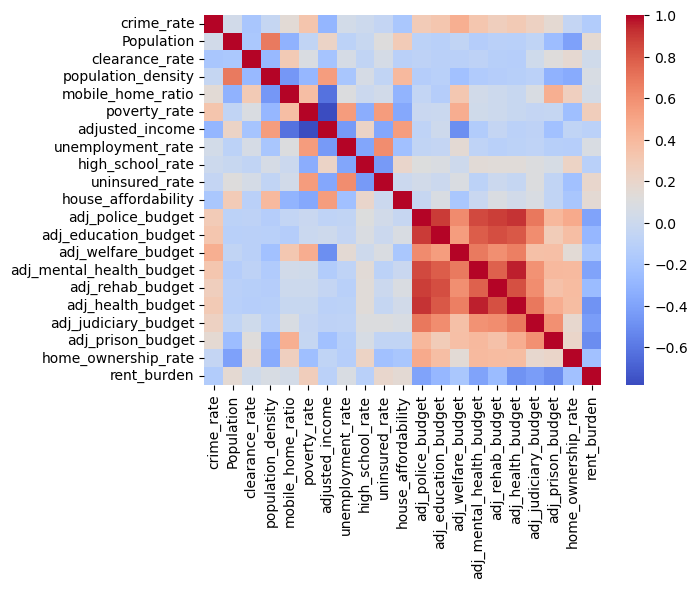

In [185]:
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.show()

### A seabon clustermap

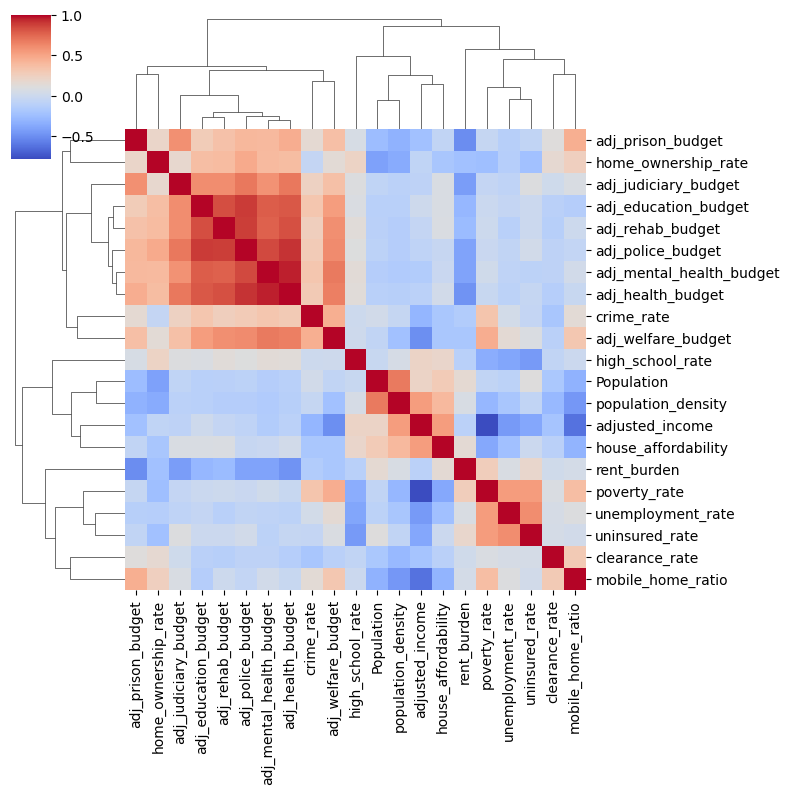

In [186]:
# Create a clustermap
sns.clustermap(correlation_matrix, cmap="coolwarm", figsize=(8, 8))
plt.show()

### A network graph visualizing the correlation 

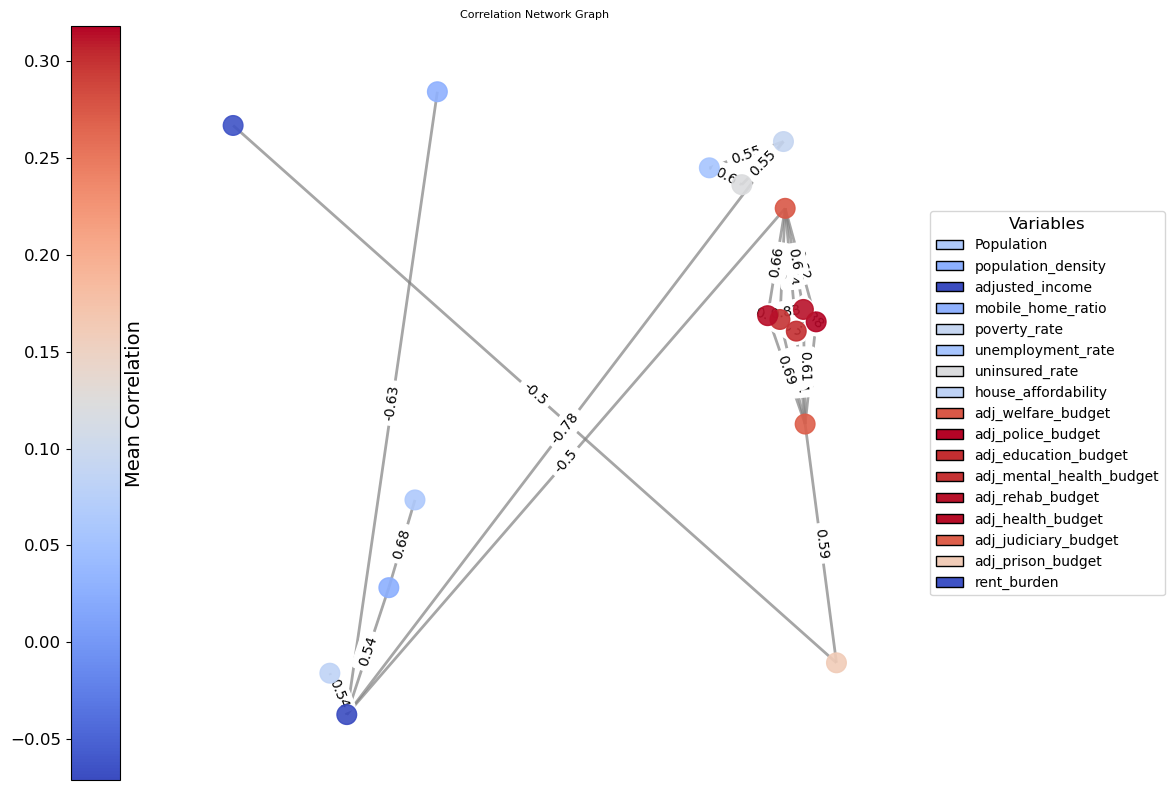

In [187]:
# Create a network graph
G = nx.Graph()

# Add nodes and edges based on correlation threshold
threshold = 0.5

"""
for i in correlation_matrix.columns:
    for j in correlation_matrix.index:
        if i != j and abs(correlation_matrix.loc[i, j]) > threshold:
            # Add weighted edges
            G.add_edge(i, j, weight=correlation_matrix.loc[i, j])
"""
# Ensure the correlation matrix is square
if not correlation_matrix.columns.equals(correlation_matrix.index):
    raise ValueError("The correlation matrix must have identical rows and columns.")


# Fill NaNs (if needed) and iterate
# correlation_matrix = correlation_matrix.fillna(0)

for i in correlation_matrix.columns:
    for j in correlation_matrix.index:
        # print(correlation_matrix.loc[i, j])

        # Ensure i != j and add edges based on the threshold
        if i != j and abs(correlation_matrix.at[i, j]) > threshold:
            G.add_edge(i, j, weight=correlation_matrix.loc[i, j])


# Filter the node_colors to include only the nodes present in the graph
graph_nodes = list(G.nodes)
node_colors = correlation_matrix.loc[graph_nodes, graph_nodes].mean(
    axis=0
)  # Compute mean only for graph nodes
norm = mcolors.Normalize(
    vmin=node_colors.min(), vmax=node_colors.max()
)  # Normalize for color mapping
cmap = plt.cm.coolwarm  # Colormap for the nodes
node_colors_mapped = [
    cmap(norm(value)) for value in node_colors
]  # Map values to colors

# Layout for nodes
pos = nx.spring_layout(G, seed=42)  # Force-directed layout for better spacing

# Start the plot with customized figure layout
fig = plt.figure(figsize=(12, 8))
grid = fig.add_gridspec(
    1, 3, width_ratios=[0.05, 0.75, 0.2]
)  # Adjust width_ratios for a thinner cbar
ax_cbar = fig.add_subplot(grid[0])  # Color bar on the left
ax_main = fig.add_subplot(grid[1])  # Main graph in the center
ax_legend = fig.add_subplot(grid[2])  # Legend on the right

# Draw the main graph
nx.draw_networkx_nodes(
    G, pos, node_size=200, node_color=node_colors_mapped, alpha=0.9, ax=ax_main
)
nx.draw_networkx_edges(G, pos, width=2, edge_color="gray", alpha=0.7, ax=ax_main)
nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels={(u, v): round(d["weight"], 2) for u, v, d in G.edges(data=True)},
    font_size=10,
    font_color="black",
    ax=ax_main,
)
ax_main.set_title(
    "Correlation Network Graph",
    fontsize=8,
)
ax_main.axis("off")  # Hide axis for the graph

# Add resized color bar with larger fonts
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=ax_cbar, orientation="vertical")
cbar.ax.tick_params(labelsize=12)  # Increase tick label font size
cbar.set_label("Mean Correlation", fontsize=14)  # Increase color bar label font size
ax_cbar.yaxis.tick_left()

# Create a legend on the right
ax_legend.axis("off")  # Hide the axes for the legend panel
legend_elements = [
    Patch(facecolor=cmap(norm(value)), edgecolor="black", label=f"{node}")
    for node, value in zip(graph_nodes, node_colors)
]
ax_legend.legend(
    handles=legend_elements,
    loc="center",
    title="Variables",
    fontsize=10,
    title_fontsize=12,
)

# Finalize the layout
plt.tight_layout()
plt.show()

In [188]:
clean_dataframe

,County,Year,Population,crime_rate,clearance_rate,population_density,unemployment_rate,adjusted_income,poverty_rate,rent_burden,...,adj_prison_budget,median_house_value,house_affordability,Category,Category_encoded,Category_Rural,Category_Suburban,Category_Urban,uninsured_rate,high_school_rate
0,Alameda,2010,1510271,0.006931,0.326901,2046.437669,11.2,294.981910,13.5,42.4,...,0.664076,590900,8.827704,Urban,2,0,0,1,0.132639,85.9
1,Alameda,2011,1527169,0.007062,0.294298,2069.334688,10.3,288.906538,13.2,42.3,...,0.649141,558300,8.296307,Urban,2,0,0,1,0.128512,86.0
2,Alameda,2012,1549193,0.007681,0.247584,2099.177507,8.8,294.803804,13.1,42.6,...,0.611663,514900,7.333818,Urban,2,0,0,1,0.123669,86.2
3,Alameda,2013,1575139,0.007453,0.251895,2134.334688,7.3,298.514628,13.0,42.6,...,0.600055,493800,6.846162,Urban,2,0,0,1,0.125603,41.8
4,Alameda,2014,1597747,0.006482,0.297316,2164.968835,5.9,312.921908,12.5,43.0,...,0.631766,509300,6.614629,Urban,2,0,0,1,0.117792,86.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,Yuba,2012,73501,0.003877,0.470175,116.668254,15.6,174.671957,22.4,45.2,...,1.113337,180700,4.343854,Rural,0,1,0,0,0.153530,78.4
698,Yuba,2013,74114,0.003670,0.496324,117.641270,13.3,173.096104,20.6,48.6,...,1.052415,171000,4.088562,Rural,0,1,0,0,0.166095,13.7
699,Yuba,2014,74755,0.003960,0.500000,118.658730,11.3,168.267257,21.6,49.1,...,1.031046,170800,4.125305,Rural,0,1,0,0,0.161760,79.6
700,Yuba,2015,75374,0.004153,0.437700,119.641270,9.3,186.248828,21.6,48.9,...,1.068289,172100,3.701075,Rural,0,1,0,0,0.142650,80.8


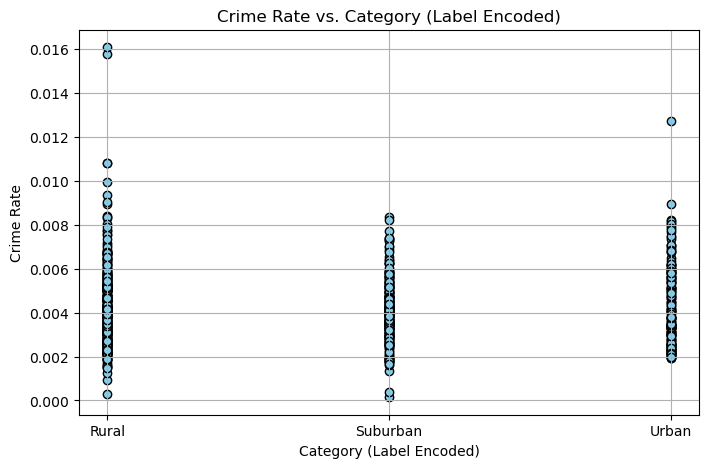

In [189]:
# Create scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(
    clean_dataframe["Category_encoded"],
    clean_dataframe["crime_rate"],
    color="skyblue",
    edgecolor="black",
)
plt.xticks([0, 1, 2], ["Rural", "Suburban", "Urban"])
plt.xlabel("Category (Label Encoded)")
plt.ylabel("Crime Rate")
plt.title("Crime Rate vs. Category (Label Encoded)")
plt.grid(True)
plt.show()

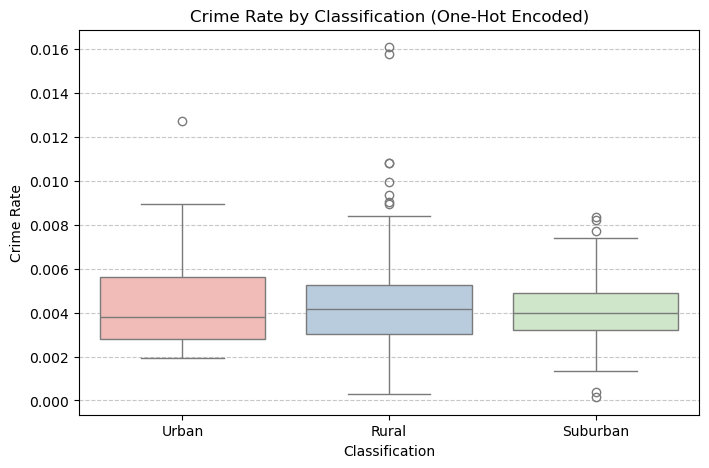

In [190]:
# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x="Category", y="crime_rate", data=clean_dataframe, palette="Pastel1")
plt.title("Crime Rate by Classification (One-Hot Encoded)")
plt.xlabel("Classification")
plt.ylabel("Crime Rate")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

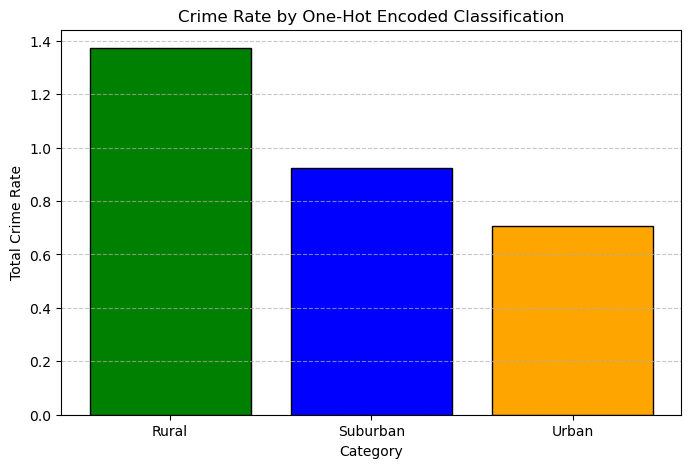

In [191]:
# Summing crime rates for each type
crime_rate_by_type = {
    "Rural": clean_dataframe["Category_Rural"].dot(clean_dataframe["crime_rate"]),
    "Suburban": clean_dataframe["Category_Suburban"].dot(clean_dataframe["crime_rate"]),
    "Urban": clean_dataframe["Category_Urban"].dot(clean_dataframe["crime_rate"]),
}

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(
    crime_rate_by_type.keys(),
    crime_rate_by_type.values(),
    color=["green", "blue", "orange"],
    edgecolor="black",
)
plt.xlabel("Category")
plt.ylabel("Total Crime Rate")
plt.title("Crime Rate by One-Hot Encoded Classification")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [192]:
# List of features for dropdown selection
feature_options = list(clean_dataframe.columns)

# Create dropdown selections for x and y axes
x_feature_dropdown = alt.binding_select(
    options=feature_options, name="Select Feature X:"
)
y_feature_dropdown = alt.binding_select(
    options=feature_options, name="Select  Feature Y:"
)
x_feature = alt.param(
    name="x_feature", bind=x_feature_dropdown, value="Population"
)  # Default X: Population
y_feature = alt.param(
    name="y_feature", bind=y_feature_dropdown, value="crime_rate"
)  # Default Y: CrimeRate

# Interactive scatter plot
scatter = (
    alt.Chart(clean_dataframe)
    .transform_calculate(
        x_value=f"datum[x_feature]",  # Dynamically calculate x-axis values
        y_value=f"datum[y_feature]",  # Dynamically calculate y-axis values
    )
    .mark_circle(size=60)
    .encode(
        x=alt.X("x_value:Q", title="X Feature"),  # Use dynamically calculated x_value
        y=alt.Y("y_value:Q", title="Y Feature"),  # Use dynamically calculated y_value
        color="Category:N",  # Color encoding by classification
        tooltip=["Population", "crime_rate", "high_school_rate", "Category"],
    )
    .add_params(x_feature, y_feature)
    .properties(width=600, height=400, title="Interactive Pairwise Scatter Plot")
    .interactive()
)

scatter

alt.Chart(...)

### Split data into train and test data

In [193]:
X = final_dataframe[features]  # Independent varaibles
y = final_dataframe["crime_rate"]  # Dependent variable

# Split data
train_data, test_data = train_test_split(
    final_dataframe, test_size=0.2, random_state=42
)
X_train, y_train = train_data[features], train_data["crime_rate"]
X_test, y_test = test_data[features], test_data["crime_rate"]

#### Ensure split ratio is accurate.

In [194]:
# Calculate the sizes
total_rows = len(final_dataframe)
train_size = len(X_train)
test_size = len(X_test)

# Check if the split is correct
print(f"Total rows: {total_rows}")
print(f"Training rows: {train_size} ({(train_size / total_rows) * 100:.2f}%)")
print(f"Testing rows: {test_size} ({(test_size / total_rows) * 100:.2f}%)")

# Verify the split
expected_test_size = total_rows * 0.2  # 20% of total rows
print(f"Expected test size: {expected_test_size:.0f}")
print(
    f"Is the split ratio correct? {'Yes' if abs(test_size - expected_test_size) < 1 else 'No'}"
)

Total rows: 702
Training rows: 561 (79.91%)
Testing rows: 141 (20.09%)
Expected test size: 140
Is the split ratio correct? Yes


#### Exploratory data analysis (EDA)

In [195]:
X_train.columns

Index(['Population', 'clearance_rate', 'population_density',
       'mobile_home_ratio', 'poverty_rate', 'adjusted_income',
       'unemployment_rate', 'high_school_rate', 'uninsured_rate',
       'house_affordability', 'adj_police_budget', 'adj_education_budget',
       'adj_welfare_budget', 'adj_mental_health_budget', 'adj_rehab_budget',
       'adj_health_budget', 'adj_judiciary_budget', 'adj_prison_budget',
       'home_ownership_rate', 'rent_burden'],
      dtype='object')

### Regression Analysis

In [196]:
# A function to fit models
def fit_models(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.DataFrame,
    y_test: pd.DataFrame,
    **models
) -> tuple[dict, dict, dict]:
    """
    Fit multiple models and compute their evaluation metrics and predictions.

    This function trains multiple machine learning models using the provided training data,
    evaluates them on both training and testing datasets, and returns the fitted models,
    evaluation metrics, and predictions.

    Parameters:
        X_train (pd.DataFrame): The feature matrix for training data.
        X_test (pd.DataFrame): The feature matrix for testing data.
        y_train (pd.DataFrame): The target/label vector for training data.
        y_test (pd.DataFrame): The target/label vector for testing data.
        models: A dictionary of machine learning models, where keys are model names
                and values are model instances (e.g., {'model_name': model_instance}).

    Returns:
        tuple[dict, dict, dict]: A tuple containing three dictionaries:
            - Fitted Models (dict):
                A dictionary where keys are model names and values are the fitted model instances.
            - Model Statistics (dict):
                A dictionary of dictionaries where keys are model names and each inner dictionary
                contains performance metrics:
                  - 'train': [mean squared error, root mean squared error, R^2 score] on training data.
                  - 'test': [mean squared error, root mean squared error, R^2 score] on testing data.
            - Predicted Values (dict):
                A dictionary of dictionaries where keys are model names and each inner dictionary
                contains predicted values:
                  - 'train': Predictions on the training data.
                  - 'test': Predictions on the testing data.

    Metrics Calculated:
        - Mean Squared Error (MSE): Measures the average squared difference between actual and predicted values.
        - Root Mean Squared Error (RMSE): Square root of MSE, providing error in the same unit as the target variable.
        - R^2 Score: Indicates the proportion of variance explained by the model (1 is perfect fit, 0 means no fit).

    Example:
        >>> from sklearn.linear_model import LinearRegression
        >>> from sklearn.ensemble import RandomForestRegressor
        >>> X_train, X_test, y_train, y_test = ...  # Load your dataset
        >>> models = {
        ...     'LinearRegression': LinearRegression(),
        ...     'RandomForest': RandomForestRegressor()
        ... }
        >>> fitted_models, stats, predictions = fit_models(X_train, X_test, y_train, y_test, **models)
        >>> print(stats['LinearRegression'])
        {
            'train': [mse_train, rmse_train, r2_train],
            'test': [mse_test, rmse_test, r2_test]
        }
        >>> print(predictions['RandomForest']['test'])  # Predictions for testing data

    Notes:
        - Ensure that the `models` dictionary contains scikit-learn compatible estimators (i.e., with `fit()` and `predict()` methods).
        - External utility functions like `mean_squared_error`, `root_mean_squared_error`, and `r2_score` must be imported.

    Raises:
        AttributeError: If any model in `models` does not have the required methods `fit` and `predict`.
    """

    model_stats = {}
    fitted_models = {}
    predicted_values = {}

    for key, model in models.items():
        # Fit the models to the training data
        model.fit(X_train, y_train)

        # Find the model predictions on the training set
        train_preds = model.predict(X_train)

        # Find the model predictions on the test set
        test_preds = model.predict(X_test)

        # Find the mse on the training set
        train_mse = mean_squared_error(y_train, train_preds)
        train_rmse = root_mean_squared_error(y_train, train_preds)
        train_r2score = r2_score(y_train, train_preds)

        # Find the mse on the test set
        test_mse = mean_squared_error(y_test, test_preds)
        test_rmse = root_mean_squared_error(y_test, test_preds)
        test_r2score = r2_score(y_test, test_preds)

        fitted_models[key] = model
        model_stats[key] = {
            "train": [train_mse, train_rmse, train_r2score],
            "test": [test_mse, test_rmse, test_r2score],
        }
        predicted_values[key] = {"train": train_preds, "test": test_preds}

    return fitted_models, model_stats, predicted_values

In [197]:
# Regression models to train
models = {
    "mlr": LinearRegression(),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

# Get return values from the function fit_models
fitted_models, models_stats, predicted_values = fit_models(
    X_train, X_test, y_train, y_test, **models
)

# Using pretty table
table = PrettyTable()
table.field_names = ["Model", "Type", "MSE", "RMSE", "r2 Score"]

for key, stat in models_stats.items():
    table.add_rows(
        [
            [key, "train data", stat["train"][0], stat["train"][1], stat["train"][2]],
            ["", "test data", stat["test"][0], stat["test"][1], stat["test"][2]],
        ],
        divider=True,
    )
table.title = "Model Performance Metrics"
table.set_style(TableStyle.DOUBLE_BORDER)
print(table)

╔═══════════════════════════════════════════════════════════════════════════════════════════════════╗
║                                     Model Performance Metrics                                     ║
╠═══════════════╦════════════╦════════════════════════╦═══════════════════════╦═════════════════════╣
║     Model     ║    Type    ║          MSE           ║          RMSE         ║       r2 Score      ║
╠═══════════════╬════════════╬════════════════════════╬═══════════════════════╬═════════════════════╣
║      mlr      ║ train data ║ 1.9733534988527294e-06 ║ 0.0014047610112943516 ║  0.4160852039767017 ║
║               ║ test data  ║ 1.680072271664149e-06  ║ 0.0012961760187814573 ║  0.2413983999211209 ║
╠═══════════════╬════════════╬════════════════════════╬═══════════════════════╬═════════════════════╣
║      xgb      ║ train data ║ 2.1382547504728564e-07 ║ 0.0004624126674814236 ║  0.9367290965762548 ║
║               ║ test data  ║ 8.859500061312878e-07  ║ 0.0009412491732433488 ║  0

### Observation from the table above
- From the table above, it seems XGBRegressor and RandomForestRegressor are performing better.
- We will use cross validations to confirm this performance ? 


## Visualize Linear regression model results 
1. Visualize coefficient importance for  linear regression
2. Visualize predicted vs true values for linear regression
3. Visualize residuals for linear regression

#### Visualize coefficient importance for  linear regression

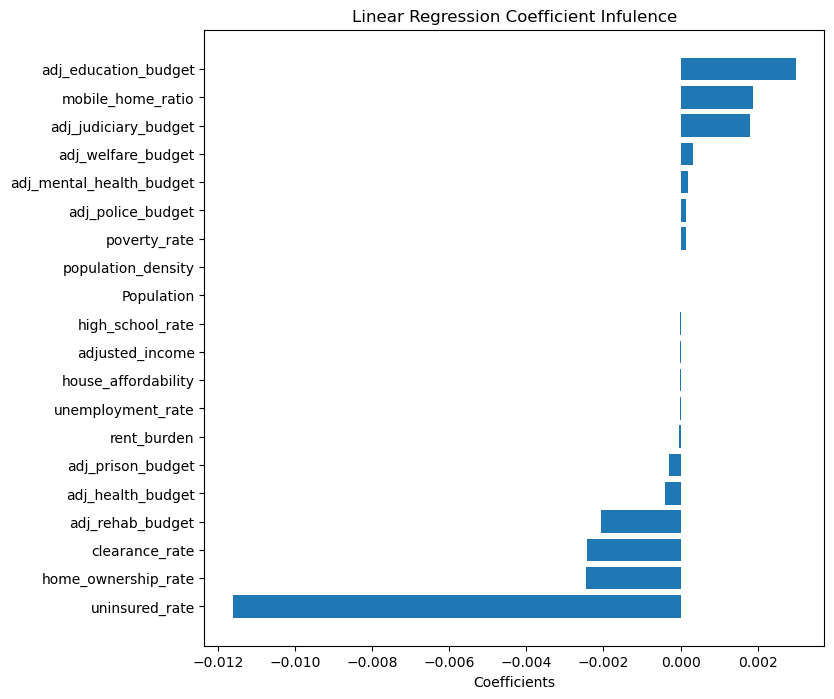

In [198]:
coeffs_mlr = fitted_models["mlr"].coef_
features = list(X_train.columns)
sorted_indices_mlr = np.argsort(coeffs_mlr)
plt.figure(figsize=(8, 8))
plt.barh([features[i] for i in sorted_indices_mlr], coeffs_mlr[sorted_indices_mlr])
plt.title("Linear Regression Coefficient Infulence")
plt.xlabel("Coefficients")
plt.show()

#### Visualize predicted vs true values for linear regression

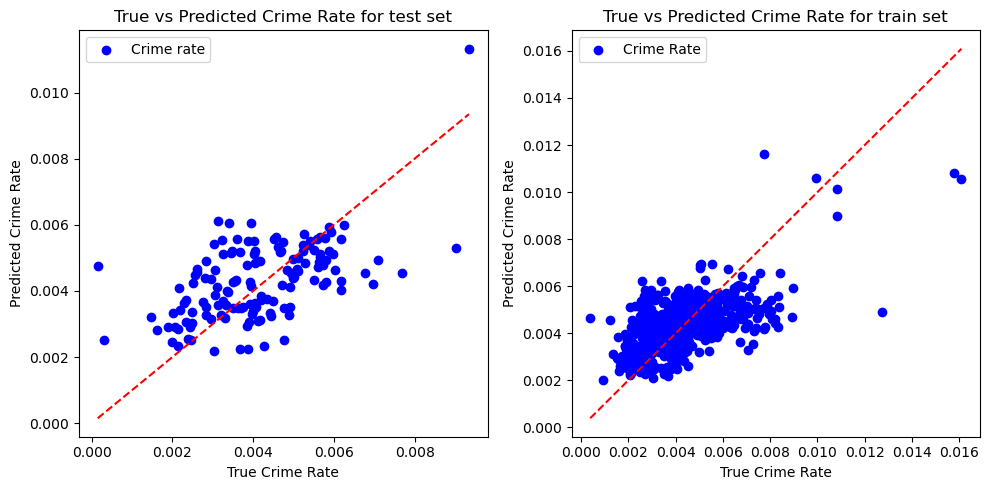

In [199]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
mlr_test_preds = predicted_values["mlr"]["test"]
mlr_train_preds = predicted_values["mlr"]["train"]

# First subplot
axes[0].scatter(y_test, mlr_test_preds, color="blue", label="Crime rate")
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color="red")
axes[0].set_title("True vs Predicted Crime Rate for test set")
axes[0].set_xlabel("True Crime Rate")
axes[0].set_ylabel("Predicted Crime Rate")
axes[0].legend()

# Second subplot
axes[1].scatter(y_train, mlr_train_preds, color="blue", label="Crime Rate")
axes[1].plot(
    [min(y_train), max(y_train)], [min(y_train), max(y_train)], "--", color="red"
)
axes[1].set_title("True vs Predicted Crime Rate for train set")
axes[1].set_xlabel("True Crime Rate")
axes[1].set_ylabel("Predicted Crime Rate")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### Visualize residuals for linear regression

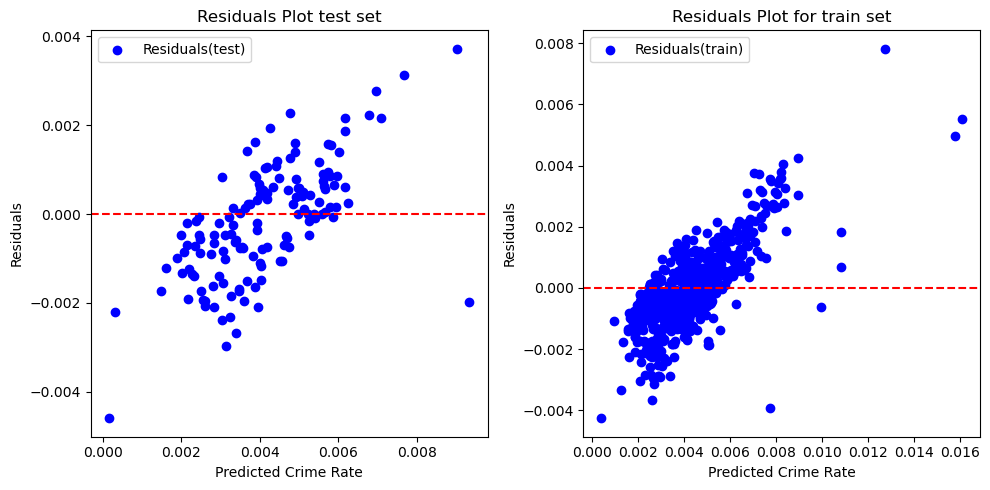

In [200]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
mlr_test_residuals = y_test - mlr_test_preds
axes[0].scatter(y_test, mlr_test_residuals, color="blue", label="Residuals(test)")
axes[0].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[0].set_title("Residuals Plot test set")
axes[0].set_xlabel("Predicted Crime Rate")
axes[0].set_ylabel("Residuals")
axes[0].legend()

# Second subplot
mlr_train_residuals = y_train - mlr_train_preds
axes[1].scatter(y_train, mlr_train_residuals, color="blue", label="Residuals(train)")
axes[1].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[1].set_title("Residuals Plot for train set")
axes[1].set_xlabel("Predicted Crime Rate")
axes[1].set_ylabel("Residuals")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### Visualize XGB regression model results 
1. Visualize feature impotance
2. Visualize predicted vs true values
3. Visualize the residuals

#### Visualize feature impotance for XGBoost

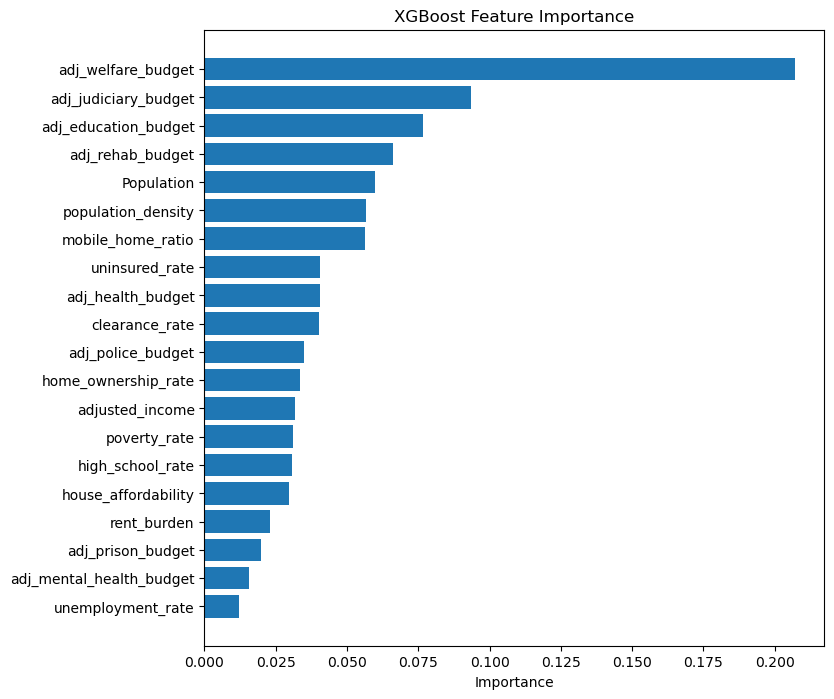

In [201]:
importance_xgb = fitted_models["xgb"].feature_importances_
sorted_indices_xgb = np.argsort(importance_xgb)
plt.figure(figsize=(8, 8))
plt.barh([features[i] for i in sorted_indices_xgb], importance_xgb[sorted_indices_xgb])
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.show()

#### Visualize predicted vs true values XGBoost

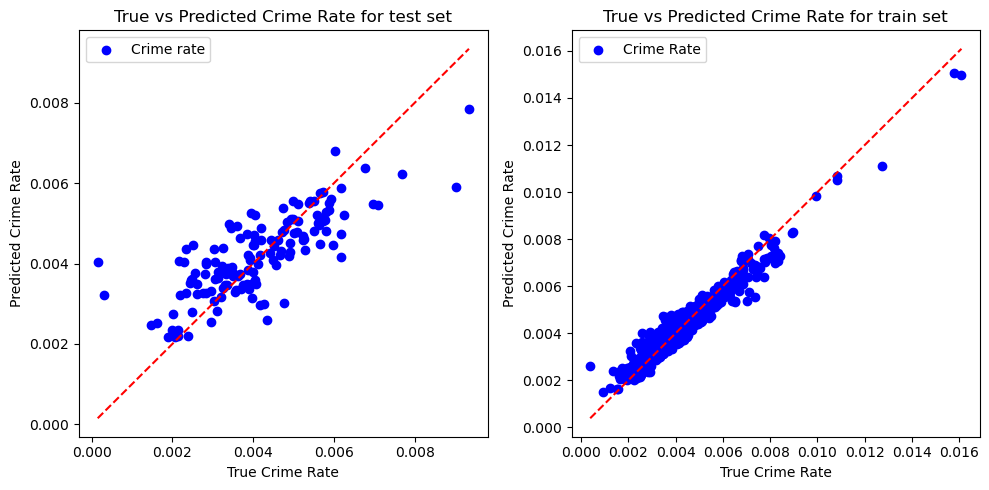

In [202]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
xgb_test_preds = predicted_values["xgb"]["test"]
xgb_train_preds = predicted_values["xgb"]["train"]

# First subplot
axes[0].scatter(y_test, xgb_test_preds, color="blue", label="Crime rate")
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color="red")
axes[0].set_title("True vs Predicted Crime Rate for test set")
axes[0].set_xlabel("True Crime Rate")
axes[0].set_ylabel("Predicted Crime Rate")
axes[0].legend()

# Second subplot
axes[1].scatter(y_train, xgb_train_preds, color="blue", label="Crime Rate")
axes[1].plot(
    [min(y_train), max(y_train)], [min(y_train), max(y_train)], "--", color="red"
)
axes[1].set_title("True vs Predicted Crime Rate for train set")
axes[1].set_xlabel("True Crime Rate")
axes[1].set_ylabel("Predicted Crime Rate")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### Visualize the residuals XGBoost

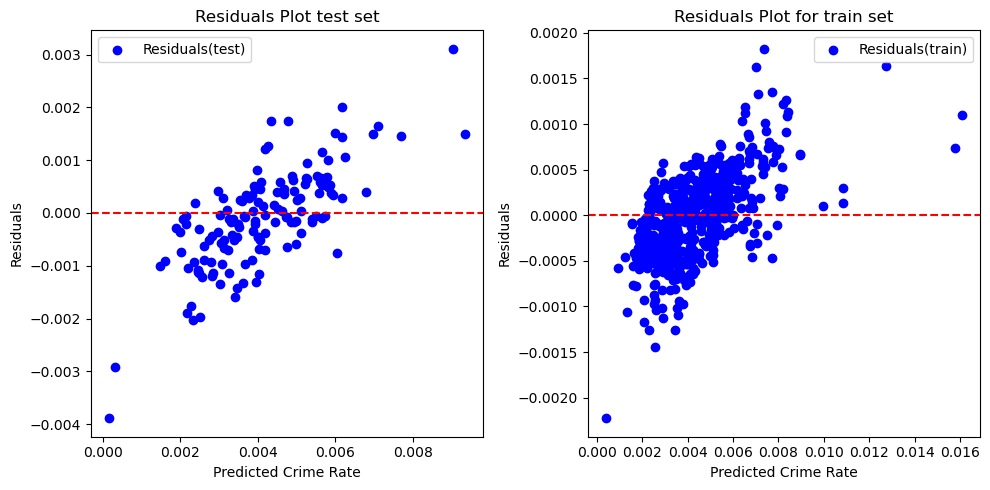

In [203]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
xgb_test_residuals = y_test - xgb_test_preds
axes[0].scatter(y_test, xgb_test_residuals, color="blue", label="Residuals(test)")
axes[0].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[0].set_title("Residuals Plot test set")
axes[0].set_xlabel("Predicted Crime Rate")
axes[0].set_ylabel("Residuals")
axes[0].legend()

# Second subplot
xgb_train_residuals = y_train - xgb_train_preds
axes[1].scatter(y_train, xgb_train_residuals, color="blue", label="Residuals(train)")
axes[1].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[1].set_title("Residuals Plot for train set")
axes[1].set_xlabel("Predicted Crime Rate")
axes[1].set_ylabel("Residuals")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Visualize Ridge regression model results 
1. Visualize feature impotance
2. Visualize predicted vs true values
3. Visualize the residuals

#### Visualize coefficient importance for Ridge regression

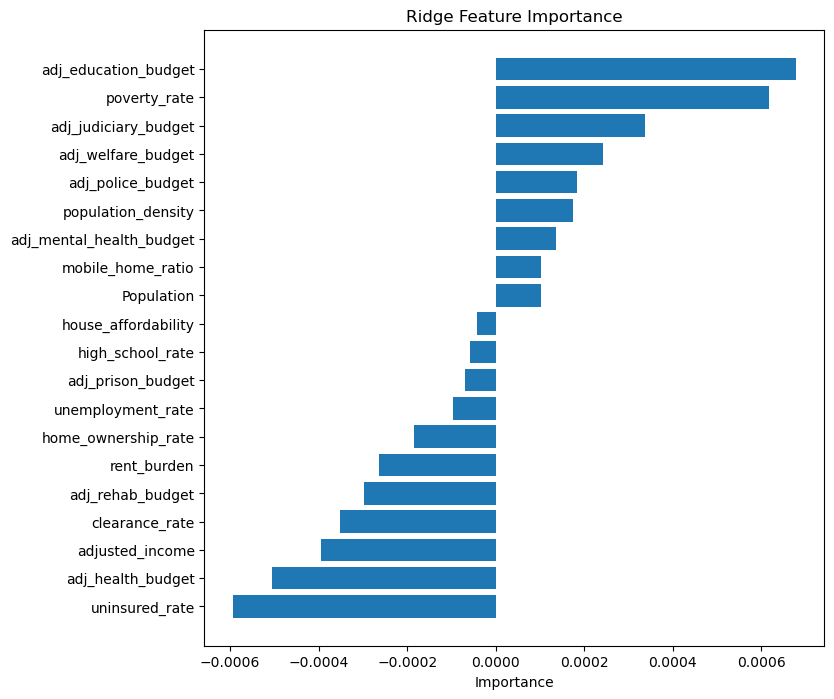

In [204]:
ridge_model = fitted_models["ridge"].named_steps["ridge"]
coeffs_ridge = ridge_model.coef_
sorted_indices_ridge = np.argsort(coeffs_ridge)
plt.figure(figsize=(8, 8))
plt.barh(
    [features[i] for i in sorted_indices_ridge], coeffs_ridge[sorted_indices_ridge]
)
plt.title("Ridge Feature Importance")
plt.xlabel("Importance")
plt.show()

#### Visualize predicted vs true values

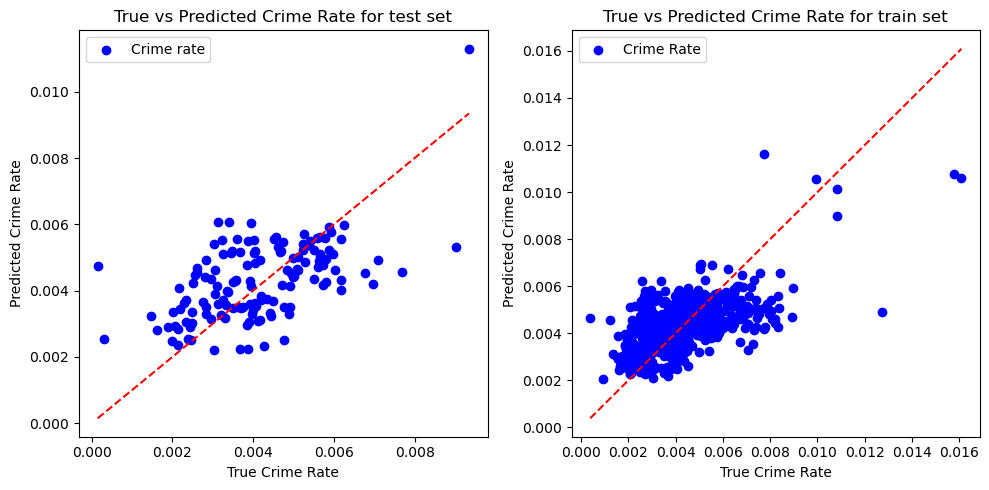

In [205]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ridge_test_preds = predicted_values["ridge"]["test"]
ridge_train_preds = predicted_values["ridge"]["train"]

# First subplot
axes[0].scatter(y_test, ridge_test_preds, color="blue", label="Crime rate")
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color="red")
axes[0].set_title("True vs Predicted Crime Rate for test set")
axes[0].set_xlabel("True Crime Rate")
axes[0].set_ylabel("Predicted Crime Rate")
axes[0].legend()

# Second subplot
axes[1].scatter(y_train, ridge_train_preds, color="blue", label="Crime Rate")
axes[1].plot(
    [min(y_train), max(y_train)], [min(y_train), max(y_train)], "--", color="red"
)
axes[1].set_title("True vs Predicted Crime Rate for train set")
axes[1].set_xlabel("True Crime Rate")
axes[1].set_ylabel("Predicted Crime Rate")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### Visualize the residuals

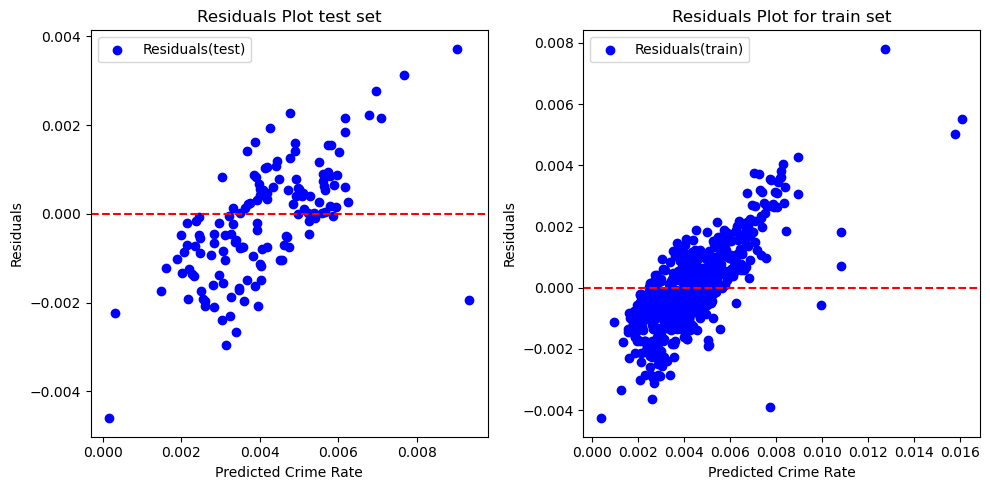

In [206]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
ridge_test_residuals = y_test - ridge_test_preds
axes[0].scatter(y_test, ridge_test_residuals, color="blue", label="Residuals(test)")
axes[0].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[0].set_title("Residuals Plot test set")
axes[0].set_xlabel("Predicted Crime Rate")
axes[0].set_ylabel("Residuals")
axes[0].legend()

# Second subplot
ridge_train_residuals = y_train - ridge_train_preds
axes[1].scatter(y_train, ridge_train_residuals, color="blue", label="Residuals(train)")
axes[1].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[1].set_title("Residuals Plot for train set")
axes[1].set_xlabel("Predicted Crime Rate")
axes[1].set_ylabel("Residuals")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### Visualize RandomForest regression model results 
1. Visualize feature impotance
2. Visualize predicted vs true values
3. Visualize the residuals

#### Visualize coefficient importance for random forest

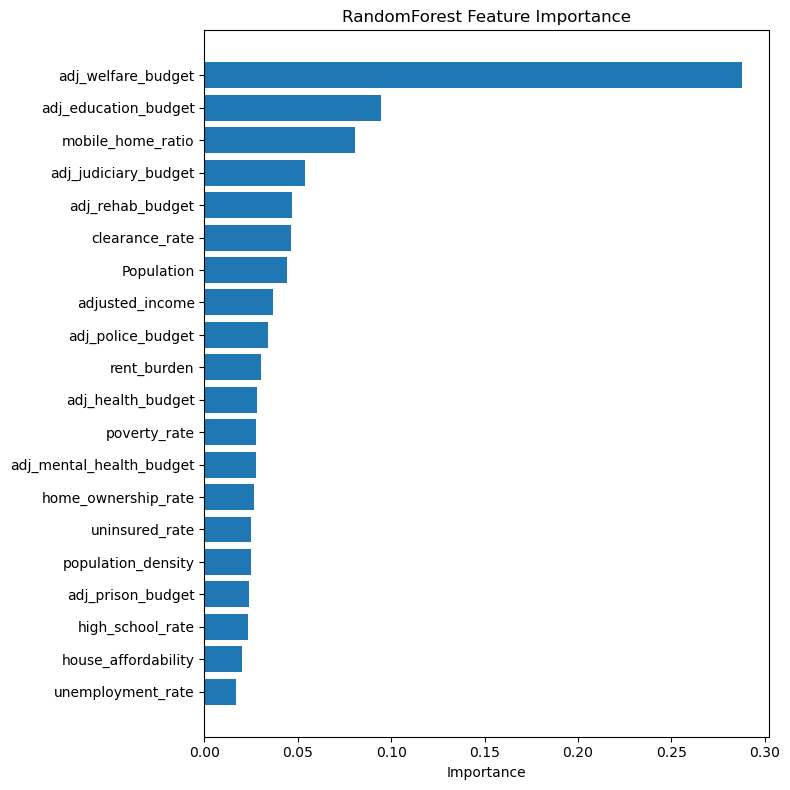

In [207]:
randonforest_model = fitted_models["random_forest"].named_steps["randomforest"]
importance_randonforest = randonforest_model.feature_importances_
sorted_indices_randonforest = np.argsort(importance_randonforest)
plt.figure(figsize=(8, 8))
plt.barh(
    [features[i] for i in sorted_indices_randonforest],
    importance_randonforest[sorted_indices_randonforest],
)
plt.title("RandomForest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

#### Visualize predicted vs true values for RandomForest

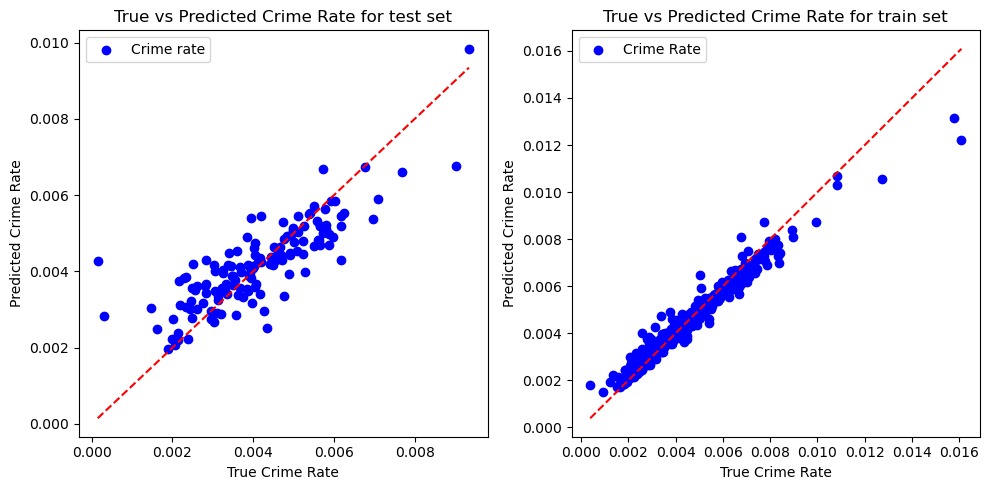

In [208]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
randomforest_test_preds = predicted_values["random_forest"]["test"]
randomforest_train_preds = predicted_values["random_forest"]["train"]

# First subplot
axes[0].scatter(y_test, randomforest_test_preds, color="blue", label="Crime rate")
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color="red")
axes[0].set_title("True vs Predicted Crime Rate for test set")
axes[0].set_xlabel("True Crime Rate")
axes[0].set_ylabel("Predicted Crime Rate")
axes[0].legend()

# Second subplot
axes[1].scatter(y_train, randomforest_train_preds, color="blue", label="Crime Rate")
axes[1].plot(
    [min(y_train), max(y_train)], [min(y_train), max(y_train)], "--", color="red"
)
axes[1].set_title("True vs Predicted Crime Rate for train set")
axes[1].set_xlabel("True Crime Rate")
axes[1].set_ylabel("Predicted Crime Rate")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### Visualize the residuals

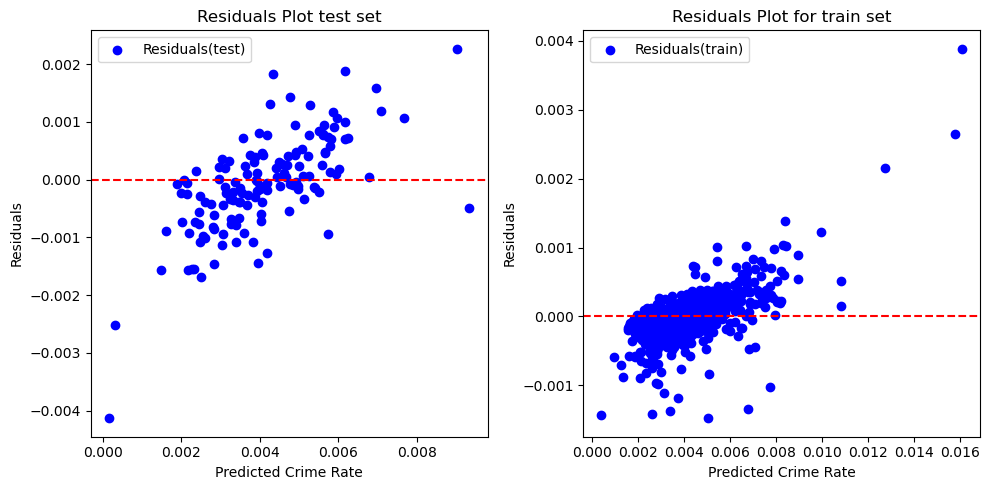

In [209]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
randomforest_test_residuals = y_test - randomforest_test_preds
axes[0].scatter(
    y_test, randomforest_test_residuals, color="blue", label="Residuals(test)"
)
axes[0].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[0].set_title("Residuals Plot test set")
axes[0].set_xlabel("Predicted Crime Rate")
axes[0].set_ylabel("Residuals")
axes[0].legend()

# Second subplot
randomforest_train_residuals = y_train - randomforest_train_preds
axes[1].scatter(
    y_train, randomforest_train_residuals, color="blue", label="Residuals(train)"
)
axes[1].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[1].set_title("Residuals Plot for train set")
axes[1].set_xlabel("Predicted Crime Rate")
axes[1].set_ylabel("Residuals")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Observations from the visuals.
From the visuals, it appears that the performance of the models  ranks as follows
1. Randonforest Regressor
2. XGBoost Regressor
3. Ridge Regressor
4. Linear Regressor

#### Principal Component Analysis
1. Standardise the training data: give all variables equal weight.
    - Use StandardScaler from sklearn to scale your data to have a mean of 0 and standard deviation of 
    

In [210]:
# Standardise the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply PCA to the training data
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Explain variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Decide the number of components to keep
# For example, keep enough components to explain 90% of variance
n_components = (
    np.argmax(cumulative_variance >= 0.9) + 1
)  # First PC where cumulative >= 90%
print(f"Number of components to retain 90% variance: {n_components}")

# Apply PCA again with the chosen number of components
pca_reduced = PCA(n_components=n_components)
X_train_reduced = pca_reduced.fit_transform(X_train_scaled)

# Show shape of reduced data
print(f"Original shape: {X_train_scaled.shape}")
print(f"Reduced shape: {X_train_reduced.shape}")

Number of components to retain 90% variance: 10
Original shape: (561, 20)
Reduced shape: (561, 10)


### Plot for PCA

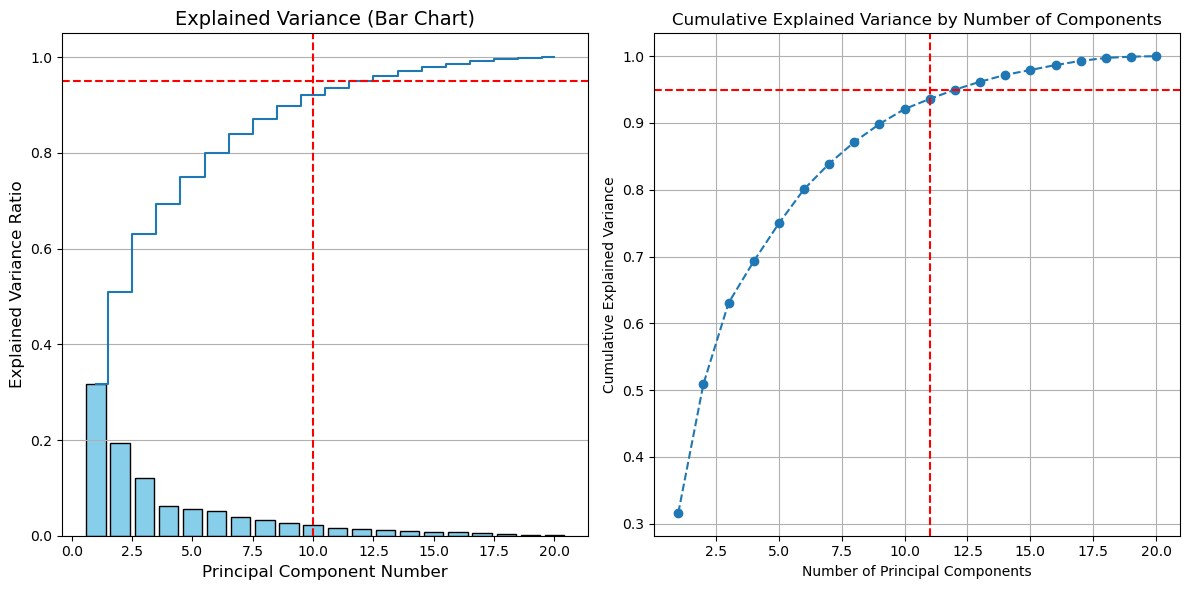

In [211]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Subplot 1: Bar chart for explained variance ratio
axes[0].bar(
    range(1, len(explained_variance) + 1),
    explained_variance,
    color="skyblue",
    edgecolor="black",
)
axes[0].step(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    where="mid",
    label="Cumulative Variance",
)
axes[0].axhline(y=0.95, color="red", linestyle="--", label="95% Threshold")
axes[0].axvline(x=n_components, color="red", linestyle="--", label="Retained 11 PCs")
axes[0].set_xlabel("Principal Component Number", fontsize=12)
axes[0].set_ylabel("Explained Variance Ratio", fontsize=12)
axes[0].set_title("Explained Variance (Bar Chart)", fontsize=14)
axes[0].grid(axis="y")

axes[1].plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o",
    linestyle="--",
)
axes[1].axhline(y=0.95, color="red", linestyle="--", label="95% Threshold")
axes[1].axvline(x=11, color="red", linestyle="--", label="Retained 11 PCs")
axes[1].set_xlabel("Number of Principal Components")
axes[1].set_ylabel("Cumulative Explained Variance")
axes[1].set_title("Cumulative Explained Variance by Number of Components")
axes[1].grid()
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Interpretaion of the scree plot

- Components to the left of the elbow are important — they explain significant variance.

- Components after the elbow contribute little and may not be worth retaining.

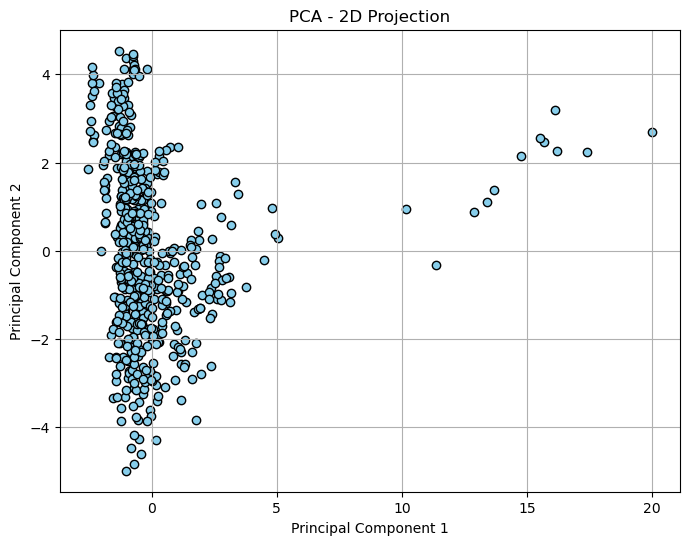

In [212]:
# Visualize the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(
    X_train_reduced[:, 0], X_train_reduced[:, 1], c="skyblue", edgecolor="black"
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA - 2D Projection")
plt.grid()
plt.show()

In [213]:
# Get the PCA loadings
loadings = pd.DataFrame(
    pca_reduced.components_.T,
    columns=[f"PC{i+1}" for i in range(n_components)],
    index=X_train.columns,
)

loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Population,-0.100219,0.179668,0.376201,0.304934,0.224210,0.075707,0.451273,0.061635,0.203853,-0.085361
clearance_rate,-0.015076,-0.160105,-0.234820,0.079626,-0.259798,0.589116,0.532834,0.075114,-0.428554,0.041953
population_density,-0.119914,0.299431,0.309159,0.213976,0.089076,-0.025580,0.327488,0.064643,0.233638,0.133104
mobile_home_ratio,0.059082,-0.309508,-0.285136,0.273495,0.288385,0.215264,-0.029547,-0.061338,0.396543,0.190244
poverty_rate,0.025192,-0.416879,0.255115,0.001199,0.215678,-0.000580,-0.033850,-0.005771,-0.179734,-0.054377
adjusted_income,-0.090192,0.447331,-0.017212,-0.082878,-0.240629,-0.000651,-0.070427,-0.039534,-0.010983,0.140049
unemployment_rate,-0.018755,-0.329558,0.247963,-0.102153,-0.268529,-0.112363,-0.030732,0.497934,0.051940,0.383072
high_school_rate,0.060356,0.227291,-0.229750,-0.016734,0.443765,0.071667,-0.129914,0.745713,-0.153582,-0.252556
uninsured_rate,-0.002774,-0.262689,0.376755,0.071173,-0.341368,0.175317,-0.164860,0.245898,0.241237,-0.253704
house_affordability,-0.038153,0.300206,0.161573,0.120910,-0.032794,0.521384,-0.444582,0.067358,-0.030610,0.447558


### Scree and biplots
### Comparing principal components 1 & 2

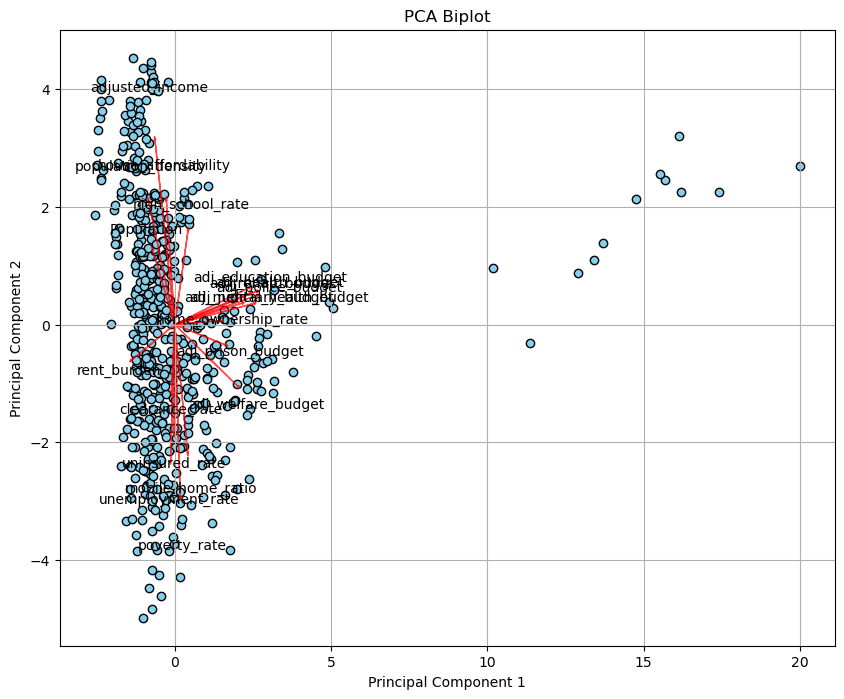

In [214]:
# Get feature loadings

# Plot biplot
plt.figure(figsize=(10, 8))

# Scatter plot of PCA scores (observations)
plt.scatter(
    X_train_reduced[:, 0], X_train_reduced[:, 1], c="skyblue", edgecolor="black"
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Biplot")

# Add arrows for feature loadings (scaled for visibility)
scale_factor = 7
for i, feature in enumerate(X_train.columns):
    plt.arrow(
        0,
        0,
        loadings["PC1"].iloc[i] * scale_factor,
        loadings[f"PC2"].iloc[i] * scale_factor,
        color="red",
        alpha=0.7,
        head_width=0.05,
    )
    plt.text(
        loadings["PC1"].iloc[i] * (scale_factor + 2),
        loadings["PC2"].iloc[i] * (scale_factor + 2),
        feature,
        color="black",
        ha="center",
        va="center",
    )

plt.grid()
plt.show()

In [215]:
import numpy as np
import plotly.graph_objects as go

# `loadings` is PCA.components_.T
scaling_factor = 2
fig = go.Figure()

# Add loadings for top 3 PCs
for i, feature in enumerate(X_train.columns):
    fig.add_trace(
        go.Scatter3d(
            x=[0, loadings["PC1"].iloc[i] * scaling_factor],
            y=[0, loadings["PC2"].iloc[i] * scaling_factor],
            z=[0, loadings["PC3"].iloc[i] * scaling_factor],
            mode="lines+text",
            line=dict(color="red", width=2),
            text=[None, feature],
            name=feature,
        )
    )

# Update the layout
fig.update_layout(
    title="Loadings for Top 3 PCs",
    scene=dict(xaxis_title="PC1(x)", yaxis_title="PC2(y)", zaxis_title="PC3(z)"),
)
fig.show()

### Cross Validatons

In [216]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Define the models with pipelines
num_splits = 5
models = {
    "LinearRegression + Scaling": Pipeline(
        [("scale", StandardScaler()), ("reg", LinearRegression())]
    ),
    "XGBoost": xgb.XGBRegressor(
        random_state=42
    ),  # No scaling needed for tree-based models
    "Ridge + Scaling": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "PCA + LinearRegression": Pipeline(
        [
            ("scale", StandardScaler()),
            (
                "pca",
                PCA(n_components=n_components),
            ),
            ("reg", LinearRegression()),
        ]
    ),
    "RandomForest": Pipeline(
        [
            ("scale", StandardScaler()),  # Optional, can be omitted for tree models
            ("forest", RandomForestRegressor(random_state=42)),
        ]
    ),
}

# Training and evaluation loop
rmses = np.zeros((len(models), num_splits))
mses = np.zeros((len(models), num_splits))
r2_scores = np.zeros((len(models), num_splits))

kfold = KFold(n_splits=num_splits, random_state=42, shuffle=True)
i = 0

for train_index, test_index in kfold.split(X_train):
    X_tt, y_tt = X_train.iloc[train_index], y_train.iloc[train_index]
    X_ho, y_ho = X_train.iloc[test_index], y_train.iloc[test_index]

    model_index = 0
    for model_name, model in models.items():
        model.fit(X_tt[features], y_tt)
        predictions = model.predict(X_ho[features])

        # Compute metrics
        rmse = np.sqrt(mean_squared_error(y_ho, predictions))
        mse = mean_squared_error(y_ho, predictions)
        r2 = r2_score(y_ho, predictions)

        rmses[model_index, i] = rmse
        mses[model_index, i] = mse
        r2_scores[model_index, i] = r2

        # print(f"Fold {i+1}, Model {model_name}: RMSE={rmse:.4f}, MSE={mse:.4f}, R^2={r2:.4f}")
        model_index += 1

    i += 1

In [217]:
from prettytable import PrettyTable

# Create a PrettyTable
table = PrettyTable()
table.field_names = [
    "Model",
    "Mean RMSE",
    "Std RMSE",
    "Mean MSE",
    "Std MSE",
    "Mean R²",
    "Std R²",
]

# Add rows with model metrics
for model_index, model_name in enumerate(models.keys()):
    table.add_row(
        [
            model_name,
            f"{rmses[model_index].mean():.6f}",
            f"{rmses[model_index].std():.6f}",
            f"{mses[model_index].mean():.6f}",
            f"{mses[model_index].std():.6f}",
            f"{r2_scores[model_index].mean():.6f}",
            f"{r2_scores[model_index].std():.6f}",
        ],
        divider=True,
    )

table.title = "Cross-Validation: Model Performance Metrics"
table.set_style(TableStyle.DOUBLE_BORDER)
print(table)

╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
║                          Cross-Validation: Model Performance Metrics                          ║
╠════════════════════════════╦═══════════╦══════════╦══════════╦══════════╦══════════╦══════════╣
║           Model            ║ Mean RMSE ║ Std RMSE ║ Mean MSE ║ Std MSE  ║ Mean R²  ║  Std R²  ║
╠════════════════════════════╬═══════════╬══════════╬══════════╬══════════╬══════════╬══════════╣
║ LinearRegression + Scaling ║  0.001478 ║ 0.000148 ║ 0.000002 ║ 0.000000 ║ 0.304158 ║ 0.129132 ║
╠════════════════════════════╬═══════════╬══════════╬══════════╬══════════╬══════════╬══════════╣
║          XGBoost           ║  0.001225 ║ 0.000233 ║ 0.000002 ║ 0.000001 ║ 0.512632 ║ 0.174704 ║
╠════════════════════════════╬═══════════╬══════════╬══════════╬══════════╬══════════╬══════════╣
║      Ridge + Scaling       ║  0.001476 ║ 0.000149 ║ 0.000002 ║ 0.000000 ║ 0.306172 ║ 0.127821 ║
╠═══════════════════

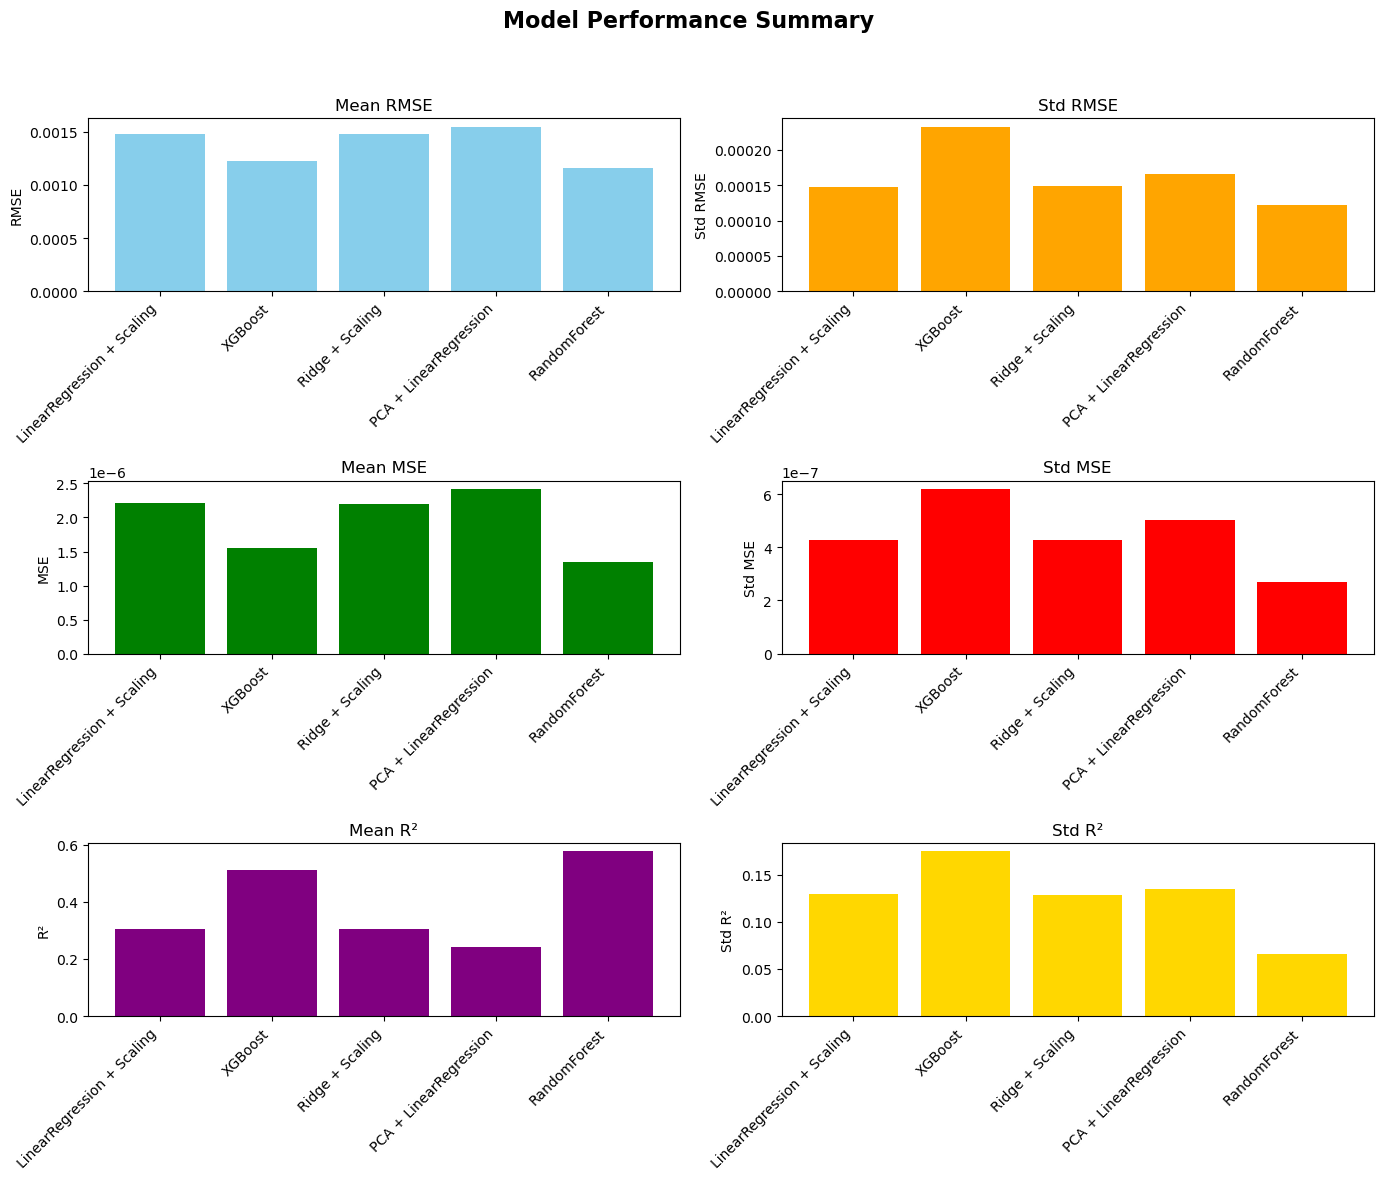

In [218]:
import matplotlib.pyplot as plt

# Subplot structure (3x2 for the 6 metrics)
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("Model Performance Summary", fontsize=16, fontweight="bold")

# Plot Mean RMSE
axes[0, 0].bar(
    models.keys(),
    [rmses[model_index].mean() for model_index in range(len(models))],
    color="skyblue",
)
axes[0, 0].set_title("Mean RMSE")
axes[0, 0].set_ylabel("RMSE")
axes[0, 0].set_xticklabels(models.keys(), rotation=45, ha="right")

# Plot Std RMSE
axes[0, 1].bar(
    models.keys(),
    [rmses[model_index].std() for model_index in range(len(models))],
    color="orange",
)
axes[0, 1].set_title("Std RMSE")
axes[0, 1].set_ylabel("Std RMSE")
axes[0, 1].set_xticklabels(models.keys(), rotation=45, ha="right")

# Plot Mean MSE
axes[1, 0].bar(
    models.keys(),
    [mses[model_index].mean() for model_index in range(len(models))],
    color="green",
)
axes[1, 0].set_title("Mean MSE")
axes[1, 0].set_ylabel("MSE")
axes[1, 0].set_xticklabels(models.keys(), rotation=45, ha="right")

# Plot Std MSE
axes[1, 1].bar(
    models.keys(),
    [mses[model_index].std() for model_index in range(len(models))],
    color="red",
)
axes[1, 1].set_title("Std MSE")
axes[1, 1].set_ylabel("Std MSE")
axes[1, 1].set_xticklabels(models.keys(), rotation=45, ha="right")

# Plot Mean R²
axes[2, 0].bar(
    models.keys(),
    [r2_scores[model_index].mean() for model_index in range(len(models))],
    color="purple",
)
axes[2, 0].set_title("Mean R²")
axes[2, 0].set_ylabel("R²")
axes[2, 0].set_xticklabels(models.keys(), rotation=45, ha="right")

# Plot Std R²
axes[2, 1].bar(
    models.keys(),
    [r2_scores[model_index].std() for model_index in range(len(models))],
    color="gold",
)
axes[2, 1].set_title("Std R²")
axes[2, 1].set_ylabel("Std R²")
axes[2, 1].set_xticklabels(models.keys(), rotation=45, ha="right")

# Adjust layout for better spacing and readability
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle

# Show the plots
plt.show()